Ми розглянемо методи кластеризації для сегментації ринку, використовуючи вибіркові дані про клієнтів із бази даних продовольчої фірми iFood, що займається доставкою їжі у Бразилії. Сегментація ринку - це поділ клієнтів на групи, які відображають схожість клієнтів у кожному кластері.   
У роботі ми здійснюємо поділ клієнтів на сегменти для оптимізації значущості кожного клієнта для бізнесу. Це буде корисним для модифікації продуктів відповідно до конкретних потреб і поведінки клієнтів і, окрім того, допоможе бізнесу задовольнити потреби кожного типу клієнтів.

## Імпорт бібліотек

In [1]:
# імпортування бібліотек
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

import numpy as np 
import pandas as pd 
import datetime
from datetime import date
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import scipy.cluster.hierarchy as shc

from kmodes.kmodes import KModes
from sklearn import metrics

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D
from pyckmeans import MultiCKMeans

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(40)

## Завантаження даних

In [2]:
# завантаження датасету
dataset = pd.read_csv("marketing.csv", sep=";")
print("Кількість рядків у датасеті:", len(dataset))
dataset.head(10)

Кількість рядків у датасеті: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   
5  7446        1967      Master       Together  62513.0        0         1   
6   965        1971  Graduation       Divorced  55635.0        0         1   
7  6177        1985         PhD        Married  33454.0        1         0   
8  4855        1974         PhD       Together  30351.0        1         0   
9  5899        1950         PhD       Together   5648.0        1         1   

  Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  NumStorePurchases  \
0  04.09.2019       58       635  ...                   10                  4   
1  08.03.2021       38        11  ...                    1                  2   
2  21.08.2020       26       426  ...                    2                 10   
3  10.02.2021       26        11  ...                    0                  4   
4  19.01.2021       94       173  ...                    3                  6   
5  09.09.2020       16       520  ...                    4                 10   
6  13.11.2019       34       235  ...                    3                  7   
7  08.05.2020       32        76  ...                    0                  4   
8  06.06.2020       19        14  ...                    0                  2   
9  13.03.2021       68        28  ...                    0                  0   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   
3                  6             0             0             0             0   
4                  5             0             0             0             0   
5                  6             0             0             0             0   
6                  6             0             0             0             0   
7                  8             0             0             0             0   
8                  9             0             0             0             0   
9                 20             1             0             0             0   

   AcceptedCmp2  Complain  Response  
0             0         0         1  
1             0         0         0  
2             0         0         0  
3             0         0         0  
4             0         0         0  
5             0         0         0  
6             0         0         0  
7             0         0         0  
8             0         0         1  
9             0         0         0  

[10 rows x 27 columns]

### Про датасет

Датасет містить 2240 рядків(об'єктів) та 27 атрибутів(колонок). Атрибути можуть бути розділені на такі групи за інформацією, яку вони містять: клієнти, продукти, просування, місце.

**Клієнти**  
Дані про клієнтів.
- ID: унікальний ідентифікатор клієнта
- Year_Birth: Рік народження клієнта
- Education: Рівень освіти клієнта
- Marital_Status: Сімейний статус клієнта
- Income: Річний дохід клієнта
- Kidhome: Кількість дітей у сім'ї клієнта
- Teenhome: Кількість підлітків у сім'ї клієнта
- Dt_Customer: Дата рєєстрації клієнта
- Recency: Кількість днів від останньої покупки клієнта
- Complain: 1, якщо клієнт скаржився за останній рік, 0 - якщо ні


**Продукти**  
Сума, що витрачена на різні продукти за останні два роки.
- MntWines: Сума, витрачена на винні продукти за останній рік
- MntFruits: Сума, витрачена на фрукти за останній рік
- MntMeatProducts: Сума, витрачена на м'ясні продукти за останній рік
- MntFishProducts: Сума, витрачена на рибу за останній рік
- MntSweetProducts: Сума, витрачена на солодощі за останній рік
- MntGoldProds: Сума, витрачена на золото за останній рік

**Просування**  
Чи прийняв користувач пропозицію за кожної рекламної кампанії.
- NumDealPurchases: Кількість покупок, що здійснив клієнт зі знижкою
- AcceptedCmp1: 1, якщо клієнт прийняв акційну пропозицію в першій кампанії, 0 - інакше
- AcceptedCmp2: 1, якщо клієнт прийняв акційну пропозицію в другій кампанії, 0 - інакше
- AcceptedCmp3: 1, якщо клієнт прийняв акційну пропозицію в третій кампанії, 0 - інакше
- AcceptedCmp4: 1, якщо клієнт прийняв акційну пропозицію в четвертій кампанії, 0 - інакше
- AcceptedCmp5: 1, якщо клієнт прийняв акційну пропозицію в п'ятій кампанії, 0 - інакше
- Response: 1, якщо клієнт прийняв акційну пропозицію в останній кампанії, 0 - інакше

**Місце**  
Кількість покупок з різних каналів продажу.
- NumWebPurchases: Кількість покупок, здійснених через вебсайт компанії
- NumCatalogPurchases: Кількість покупок, здійснений з використанням каталогу продуктів
- NumStorePurchases: Кількість покупок, здійснених в магазині
- NumWebVisitsMonth: Кількість відвідувань вебсайту компанії за останній місяць

## Очищення даних  
Щоб з'ясувати, які кроки потрібно зробити для очищення даних, треба поглянути на саму інформацію, що міститься в даних.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**Із виводу вище, бачимо, що:**
- Є пропущені значення в колонці Income
- Dt_Customer, що вказує на дату приєднання клієнта, не є типом DateTime, а має тип object
- У нашому датасеті є деякі категорійні змінні, які в в самому датафреймі мають тип object. 

Перш за все, приберемо рядки, що містять пропущені рядки в колонці Income.

In [4]:
# Видаляємо пропущені значення
dataset = dataset.dropna()
print("Кількість рядків після вилучення пустих рядків із пропущеними значеннями в колонці Income:", len(dataset))

Кількість рядків після вилучення пустих рядків із пропущеними значеннями в колонці Income: 2216


Після цього, змінюємо тип даних у колонці Dt_Customer, що вказує на дату приєднання клієнта до компанії.

In [5]:
dataset["Dt_Customer"] = pd.to_datetime(dataset["Dt_Customer"])
dates = dataset["Dt_Customer"]

Тепер створюємо колонку, що міститиме дані про кількість днів, відколи клієнти почали робити покупки в магазині щодо найновішої записаної дати і назвемо її Customer_Days, при цьому використовуючи колонку Dt_Customer.

In [6]:
# Створення колонки Customer_Days
days = []
td = np.datetime64('2022-05-17')

for i in dates:
    delta = td - i
    days.append(delta)
    
days_int = []
for i in days:
    d = i.days
    days_int.append(d)

dataset["Customer_Days"] = days_int

Перейдемо до дослідження унікальних значень в категоріальних змінних, щоб отримати чітке уявлення про дані.

In [7]:
print("Категорії у колонці Marital_Status:\n", dataset["Marital_Status"].value_counts(), "\n")
print("Категорії у колонці Education:\n", dataset["Education"].value_counts())

Категорії у колонці Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Категорії у колонці Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


**Далі виконуються такі кроки для створення нових, необхідних у подальшому аналізі, колонок даних:**
- Створення колонки Age, використовуючи колонку Year Birth, що буде вказувати на вік кожного клієнта
- Створення колонки Spent, що вказуватиме на суму, витрачену клієнтом на усі категорії продуктів за 2 роки(сума усіх витрат)
- Створення колонки Living_With із Marital_Status, щоб виділити у якій сімейній ситуації щодо проживання перебуває клієнт
- Створення колонки Children, яка вказуватиме на загальну кількість дітей у сім'ї(сума колонок Kidhome та Teenhome)
- Створення колонки Family_Size, що міститиме інформацію про розмір сім'ї кожного клієнта
- Створення колнки Parenthood, яка вказуватиме чи має клієнт дітей
- Модифікація колонки Education, за допомогою звуження кількості категорій до трьох
- Видалення всіх непотрібних в подальшому аналізі колонок

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

In [9]:
# Вік клієнта на сьогодні
dataset["Age"] = 2022-dataset["Year_Birth"]

# Загальні витрати
dataset["Spent"] = dataset["MntWines"]+ dataset["MntFruits"]+ dataset["MntMeatProducts"]+ dataset["MntFishProducts"]+ dataset["MntSweetProducts"]+ dataset["MntGoldProds"]

# Виділимо сімейний статус як Alone та Partner
dataset["Living_With"] = dataset["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

# Кількість дітей у сім'ї клієнта
dataset["Children"] = dataset["Kidhome"]+ dataset["Teenhome"]

# Кількість членів у сім'ї
dataset["Family_Size"] = dataset["Living_With"].replace({"Alone": 1, "Partner":2})+ dataset["Children"]

# Колонка, що вказує на те, чи має клієнт дітей
dataset["Parenthood"] = np.where(dataset.Children> 0, 'Parent', 'Not a Parent')

# Поділ рівнів освіти на 3 групи
dataset["Education"] = dataset["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

# Для ясності перейменуємо деякі колонки
dataset = dataset.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

# Видаляємо зайві колонки
to_drop = ["Marital_Status", "Dt_Customer", "Year_Birth", "ID"]
dataset = dataset.drop(to_drop, axis=1)

Тепер поглянемо на статистичні показники датасету:

In [10]:
dataset.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.324007     0.441787     0.505415    49.012635   305.091606   
std     25172.997276     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain     Response  \
count   2216.000000   2216.000000   2216.000000  2216.000000  2216.000000   
mean       0.073105      0.064079      0.013538     0.009477     0.150271   
std        0.260367      0.244950      0.115588     0.096907     0.357417   
min        0.000000      0.000000      0.000000     0.000000     0.000000   
25%        0.000000      0.000000      0.000000     0.000000     0.000000   
50%        0.000000      0.000000      0.000000     0.000000     0.000000   
75%        0.000000      0.000000      0.000000     0.000000     0.000000   
max        1.000000      1.000000      1.000000     1.000000     1.000000   

       Customer_Days          Age        Spent     Children  Family_Size  
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean      674.309567    53.179603   607.075361     0.947202     2.592509  
std       232.804957    11.985554   602.900476     0.749062     0.905722  
min       162.000000    26.000000     5.000000     0.000000     1.000000  
25%       502.000000    45.000000    69.000000     0.000000     2.000000  
50%       675.000000    52.000000   396.500000     1.000000     3.000000  
75%       849.000000    63.000000  1048.000000     1.000000     3.000000  
max      1225.000000   129.000000  2525.000000     3.000000     5.000000  

[8 rows x 27 columns]

Наведена вище статистика показує деякі невідповідності у середньому Income та Age і в максимальному Income та Age.

Максимальний вік становить 129 років, чого не може бути.

Тому треба поглянути на дані ширше.

<Figure size 576x396 with 0 Axes>

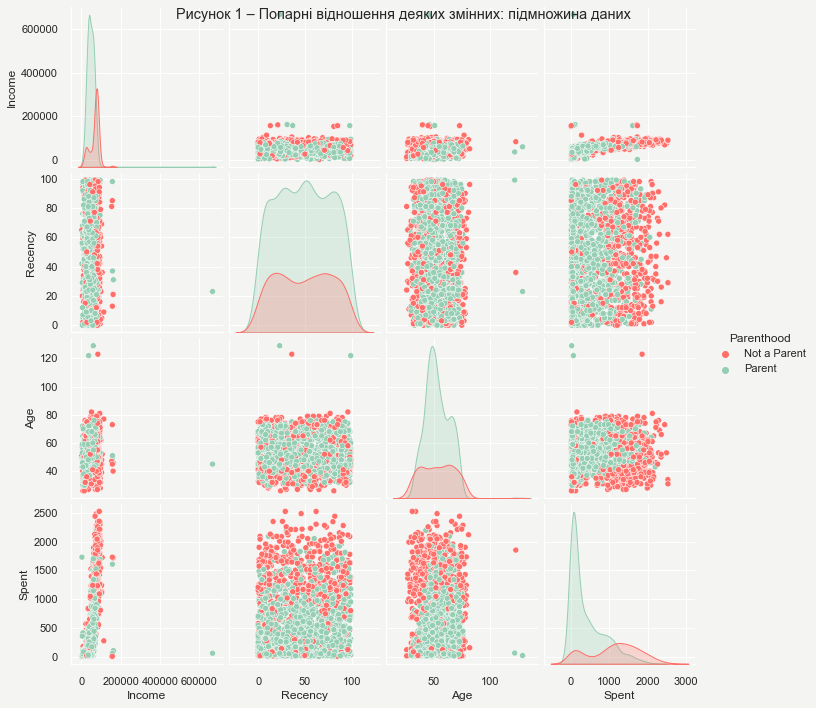

In [11]:
# Для зображення деяких обраних колонок
# Вибираємо кольори
sns.set(rc={"axes.facecolor":"#f4f5f2","figure.facecolor":"#f4f5f2"})

pallet1 = ["#edc951", "#ff6f69"]
cmap1 = matplotlib.colors.ListedColormap(pallet1)
pallet2 = ["#bd352d", "#f0a122"]
cmap2 = matplotlib.colors.ListedColormap(pallet2)
pallet3 = ["#611b17", "#d6a85c"]
cmap3 =  matplotlib.colors.ListedColormap(pallet3)

pallet4 = ["#3a8c7e", "#522d5c"]
cmap4 = matplotlib.colors.ListedColormap(pallet4)
pallet5 = ["#84d1c4", "#49054d"]
cmap5 = matplotlib.colors.ListedColormap(pallet5)
pallet6 = ["#04c2a1", "#472c4a"]
cmap6 =  matplotlib.colors.ListedColormap(pallet6)

# Будуємо графіки з такими змінними
for_plotting = [ "Income", "Recency", "Age", "Spent", "Parenthood"]
plt.figure()
pp = sns.pairplot(dataset[for_plotting], hue = "Parenthood",palette = (["#ff6f69", "#96ceb4"]))
pp.fig.suptitle("Рисунок 1 – Попарні відношення деяких змінних: підмножина даних")
plt.show();

Очевидно, що в колонках Age та Income є кілька викидів. Їх варто видалити, щоб вони не впливали на подальші результати.

In [12]:
# Видалення викидів за рахунок встановлення обмеження на ці дані
dataset = dataset[(dataset["Age"] < 90)]
dataset = dataset[((dataset["Income"] < 110000) & (dataset["Income"] > 2700))]

print("Кількість рядків у датасеті після видалення викидів:", len(dataset))

Кількість рядків у датасеті після видалення викидів: 2202


Дані після видалення викидів.

<Figure size 576x396 with 0 Axes>

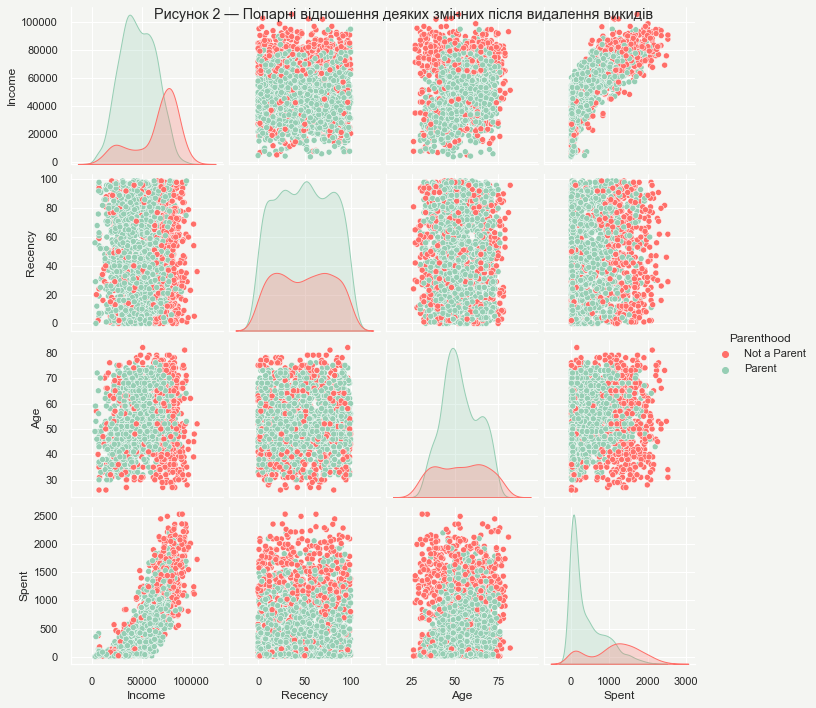

In [13]:
for_plotting = ["Income", "Recency", "Age", "Spent", "Parenthood"]
plt.figure()
pp = sns.pairplot(dataset[for_plotting], hue = "Parenthood",palette = (["#ff6f69", "#96ceb4"]))
pp.fig.suptitle("Рисунок 2 — Попарні відношення деяких змінних після видалення викидів")
plt.show();

In [14]:
dataset.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2202.000000  2202.000000  2202.000000  2202.000000  2202.000000   
mean    51638.950500     0.442325     0.507266    49.023161   306.578111   
std     20630.781799     0.537201     0.544429    28.936863   337.537575   
min      3502.000000     0.000000     0.000000     0.000000     0.000000   
25%     35208.500000     0.000000     0.000000    24.000000    24.000000   
50%     51301.000000     0.000000     0.000000    49.000000   178.500000   
75%     68279.250000     1.000000     1.000000    74.000000   507.000000   
max    105471.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2202.000000  2202.000000  2202.000000  2202.000000  2202.000000  ...   
mean     26.437330   164.751135    37.806540    27.045413    44.114896  ...   
std      39.800809   215.325912    54.845177    40.845202    51.747754  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    25.000000  ...   
75%      33.000000   232.000000    50.000000    33.750000    56.750000  ...   
max     199.000000   984.000000   259.000000   198.000000   321.000000  ...   

       AcceptedCmp5  AcceptedCmp1  AcceptedCmp2     Complain     Response  \
count   2202.000000   2202.000000   2202.000000  2202.000000  2202.000000   
mean       0.073115      0.064487      0.013624     0.009083     0.151226   
std        0.260385      0.245674      0.115950     0.094891     0.358351   
min        0.000000      0.000000      0.000000     0.000000     0.000000   
25%        0.000000      0.000000      0.000000     0.000000     0.000000   
50%        0.000000      0.000000      0.000000     0.000000     0.000000   
75%        0.000000      0.000000      0.000000     0.000000     0.000000   
max        1.000000      1.000000      1.000000     1.000000     1.000000   

       Customer_Days          Age        Spent     Children  Family_Size  
count    2202.000000  2202.000000  2202.000000  2202.000000  2202.000000  
mean      674.634423    53.090372   606.733424     0.949591     2.594914  
std       232.827880    11.700624   601.432509     0.749195     0.905499  
min       162.000000    26.000000     5.000000     0.000000     1.000000  
25%       502.250000    45.000000    69.000000     0.000000     2.000000  
50%       675.000000    52.000000   397.000000     1.000000     3.000000  
75%       849.000000    63.000000  1046.500000     1.000000     3.000000  
max      1225.000000    82.000000  2525.000000     3.000000     5.000000  

[8 rows x 27 columns]

На цьому етапі дані є досить чистими. Тому перейдемо до кластеризації.

## Кластеризація  

У цій роботі ми будемо кластеризувати окремо два набори даних: один із них буде містити інформацію про купівельну поведінку клієнтів(витрати), інший - про кількість покупок із різних каналів продажу(покупки). Визначимо, яка кластеризація краще розділяє клієнтів і опишемо її.


**Етапи кластеризації:**
- Застосування Методу ліктя(Elbow method), Методу ситуету(Silhouette method) для визначення оптимальної кількості кластерів, за потреби - використання індексів оцінки кластеризації
- Кластеризація за допомогою методу к-середніх та агломеративної кластеризації(метод Варда та метод далекого сусіда)
- Дослідження кластерів, утворених за допомогою діаграми розсіювання

In [15]:
# Створення набору даних з інформацією про купівельну поведінку клієнтів
selected_columns = dataset[["Wines","Fruits", "Meat", "Fish", "Sweets", "Gold"]] 
d_purchasing = selected_columns.copy()

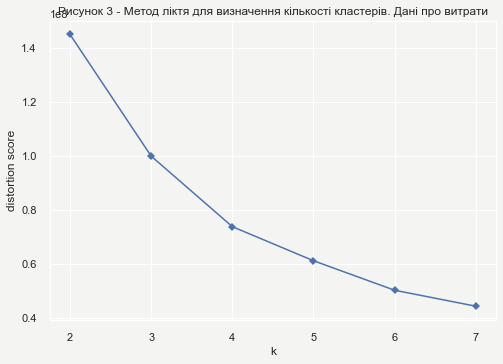

In [16]:
# Метод ліктя для знаходження кількості кластерів для методу k-середніх
elbow_m = KElbowVisualizer(KMeans(), k=7, timings = False, locate_elbow=False, title = "Рисунок 3 - Метод ліктя для визначення кількості кластерів. Дані про витрати")
elbow_m.fit(d_purchasing)
elbow_m.show();

Наведений вище графік вказує, що чотири або три кластери - можлива оптимальна кількість кластерів для цих даних.  
Також потрібно поглянути на результати інших методів пошуку оптимальної кількості кластерів, щоб вибір k був достатньо обгрунтованим. 

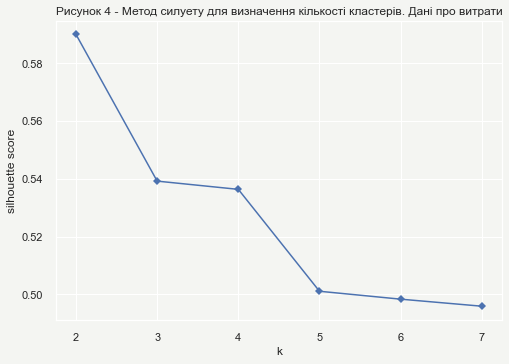

In [17]:
# Метод силуету для визначення кількості кластерів

visualizer = KElbowVisualizer(KMeans(), k=(2,8), metric = 'silhouette', timings= False, locate_elbow=False, title = 'Рисунок 4 - Метод силуету для визначення кількості кластерів. Дані про витрати')
visualizer.fit(d_purchasing)
visualizer.show();

Метод силуету пропонує обрати нам кількість кластерів рівну двом.
Скористаємося ще двома індексами оцінки якості кластеризації, щоб остаточно вирішити, яку кількість кластерів все ж варто обрати.

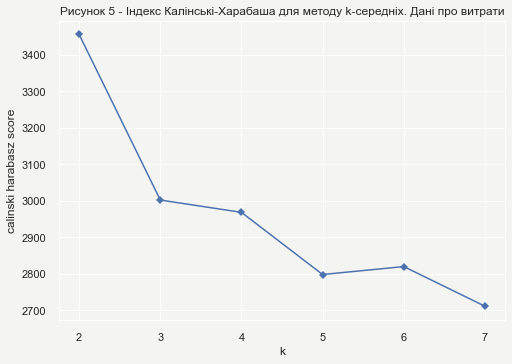

In [18]:
# Індекс Калінські-Харабаша для методу k-середніх

visualizer = KElbowVisualizer(KMeans(), k=(2,8), metric = 'calinski_harabasz', timings= False, locate_elbow=False, title = 'Рисунок 5 - Індекс Калінські-Харабаша для методу k-середніх. Дані про витрати')
visualizer.fit(d_purchasing) 
visualizer.show();

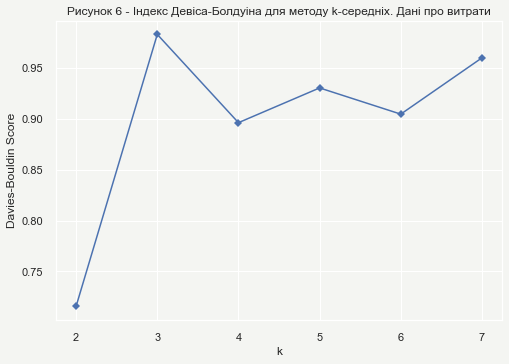

In [19]:
# Індекс Девіcа-Болдуіна для методу k-середніх

res = {}

for i in range(2,8):
    kmeans = KMeans(n_clusters=i, random_state=55)
    labels = kmeans.fit_predict(d_purchasing)
    db_index = davies_bouldin_score(d_purchasing, labels)
    res.update({i: db_index})
    
plt.plot(list(res.keys()), list(res.values()), marker = "D")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Score")
plt.title('Рисунок 6 - Індекс Девіcа-Болдуіна для методу k-середніх. Дані про витрати')
plt.show();

Обидва графіки показують, що найкращий вибір для k рівний двом(індекс Калінські-Харабаша повинен бути найвищим, а Девіса-Болдуіна найнижчим). Тому для методу k-середніх будемо ділити дані на два кластери.

Перед застосуванням методів ієрархічної кластеризації, поглянемо, яку кількість кластерів пропонує нам взяти дендрограма.

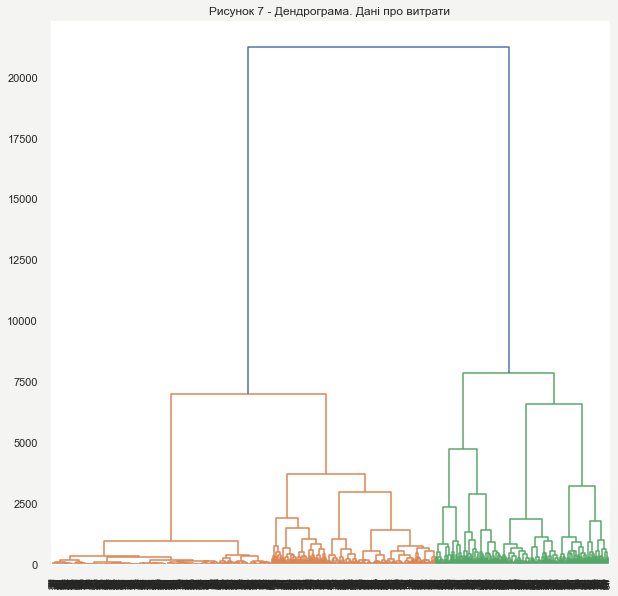

In [20]:
# Дендрограма для ієрархічної кластеризації

plt.figure(figsize=(10, 10))  
plt.title("Рисунок 7 - Дендрограма. Дані про витрати")  
dend = shc.dendrogram(shc.linkage(d_purchasing, method='ward'))

З дендрограми бачимо, що найкраще - взяти два кластери.

**Метод k-середніх, метод Варда та метод далекого сусіда**

Сформуємо кластери трьома методами(метод k-середніх, метод Варда та метод далекого сусіда) із даних, що містять в собі інформацію про купівельну поведінку клієнтів. Після цього - поглянемо на сформовані кластери у просторі головних компонент.

In [21]:
# Метод k-середніх
k_means = KMeans(n_clusters = 2, init = 'k-means++', random_state = 55)

# підганяємо модель і передбачаємо кластери
cl_kmeans = k_means.fit_predict(d_purchasing)

# Додаємо змінну Clusters_kmeans до вихідного фрейму даних
dataset["Clusters_kmeans"] = cl_kmeans


# Модель агломеративної кластеризації к = 2 методом Ворда
agc = AgglomerativeClustering(n_clusters=2, linkage = 'ward')

# підганяємо модель і передбачаємо кластери
cl_agc = agc.fit_predict(d_purchasing)

# Додаємо змінну Clusters_ward до вихідного фрейму даних.
dataset["Clusters_ward"]= cl_agc


# Модель агломеративної кластеризації к = 2 методом далекого сусіда
agc_compl = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')

# підганяємо модель і передбачаємо кластери
cl_agc_compl = agc_compl.fit_predict(d_purchasing)

# Додаємо змінну Clusters_ward до вихідного фрейму даних.
dataset["Clusters_complete"]= cl_agc_compl

## Зменшення розмірності  

Набір даних, що містить інформацію про купівельну поведінку клієнтів складається із багатьох ознак(Wines, Fruits, Meat, Fish, Sweets, Gold). Чим більша кількість ознак, тим важче із ними працювати. Багато з них є корельованими, а отже, зайві. Тому потрібно зменшити розмірність для об'єктів, перш ніж кластеризувати їх.  
Зменшення розмірності - це зменшення кількості випадкових величин, що розглядаються, шляхом отримання набору головних компонент.

**Метод головних компонент(МГК, Principal component analysis(PCA))** - це метод зменшення розмірності даних, при якому втрата інформації мінімізована. Він з'єднує корельовані ознаки і створює таку ж кількість ознак, що не корелюються одна з одною, і стискає більшу кількість інформації у перші компоненти, що допомагає впоратися з мультиколінеарністю.

**Кроки у цьому розділі:**
- Зменшення розмірності цього набору даних за допомогою МГК
- Побудова зменшеного набору даних 

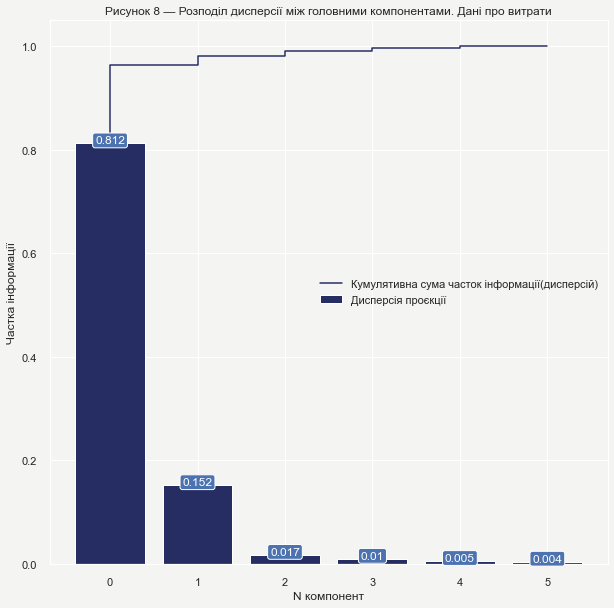

In [22]:
pca = PCA()
pca.fit(d_purchasing)

def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        a = round(y_list[i-1], 3)
        plt.annotate(a, (i-1,y_list[i-1]), c='w', ha="center", bbox=dict(boxstyle='round', pad=0.2, fc='b', alpha=1))

cumsum_eigenv = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 10))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_,  label="Дисперсія проєкції", color = "#252d63")
add_value_label(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.step(range(0, len(cumsum_eigenv)), cumsum_eigenv, label="Кумулятивна сума часток інформації(дисперсій)", color = "#252d63")
plt.xlabel("N компонент")
plt.ylabel("Частка інформації")
plt.legend(loc="center right")
plt.title("Рисунок 8 — Розподіл дисперсії між головними компонентами. Дані про витрати")
plt.show();

Оберемо три перших головних компоненти, які містять у собі біля 98% інформації, що є дуже гарним показником.

In [23]:
pca = PCA(n_components=3)
pca.fit(d_purchasing)
PCA_purchasing = pd.DataFrame(pca.transform(d_purchasing), columns=(["column1","column2", "column3"]))
PCA_purchasing.describe().T

count          mean         std         min         25%         50%  \
column1  2202.0  8.260624e-15  370.702369 -352.660012 -323.719399 -142.235853   
column2  2202.0  5.988952e-15  160.294357 -618.532898  -50.491695  -10.354834   
column3  2202.0  4.130312e-16   53.898269 -190.842740  -25.186282  -14.318649   

                75%          max  
column1  242.003114  1221.962931  
column2   20.678249   741.989278  
column3   15.155878   269.694096

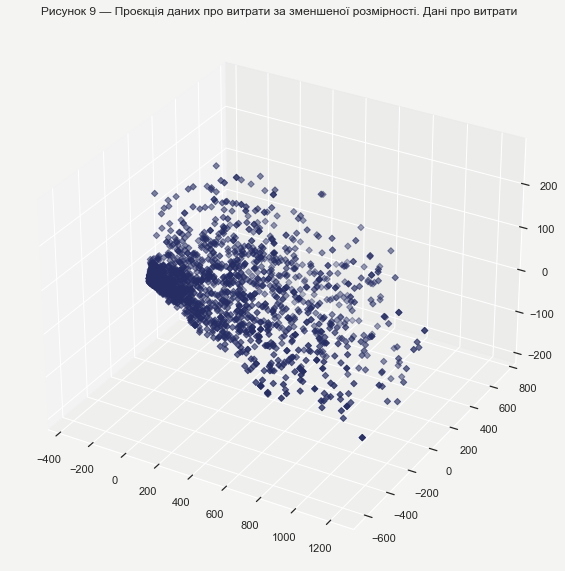

In [24]:
# Проєкція даних за зменшеної розмірності
x = PCA_purchasing["column1"]
y = PCA_purchasing["column2"]
z = PCA_purchasing["column3"]

# Побудова
fig = plt.figure(figsize=(10,10))
p = fig.add_subplot(111, projection = "3d")
p.scatter(x, y, z, c="#252d63", marker="D" )
p.set_title("Рисунок 9 — Проєкція даних про витрати за зменшеної розмірності. Дані про витрати")
plt.show();

Тепер поглянемо на кластеризовані різними методами дані щодо купівельної поведінки у просторі трьох головних компонент.

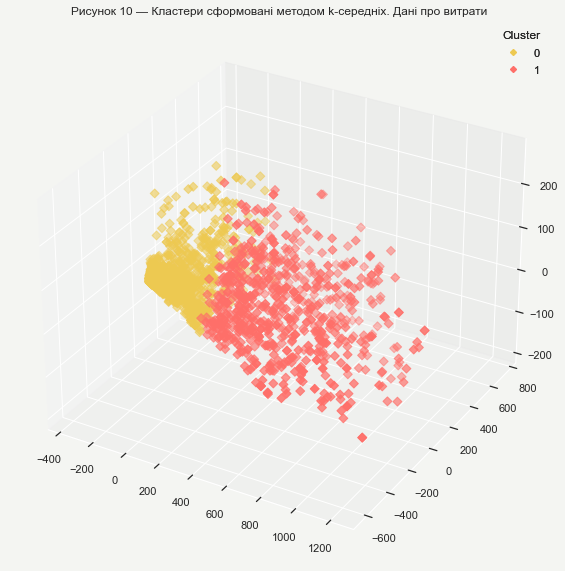

In [25]:
# Побудова графіку із кластерами
x = PCA_purchasing["column1"]
y = PCA_purchasing["column2"]
z = PCA_purchasing["column3"]

fig = plt.figure(figsize=(10,10))
p = plt.subplot(111, projection = "3d", label = "bla")
scatter = p.scatter(x, y, z, s = 40, c = dataset["Clusters_kmeans"], marker = 'D', cmap = cmap1)
p.set_title("Рисунок 10 — Кластери сформовані методом k-середніх. Дані про витрати")
legend1 = p.legend(*scatter.legend_elements(num=1), loc="upper right", title="Cluster")
p.add_artist(legend1)
plt.show();

Раніше із дендрограми ми бачили, що для агломеративної кластеризації варто обрати k рівним двом.

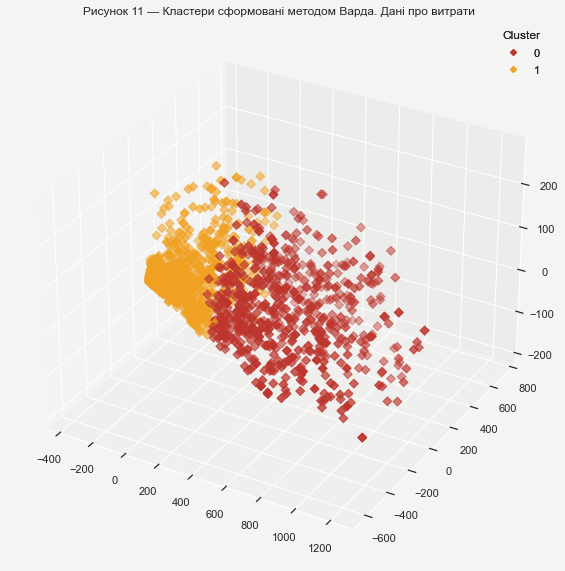

In [26]:
# Побудова графіку із кластерами сформованими методом Варда

fig = plt.figure(figsize = (10,10))
p = plt.subplot(111, projection = "3d", label = "bla")
scatter = p.scatter(x, y, z, s = 40, c = dataset["Clusters_ward"], marker ='D', cmap = cmap2)
p.set_title("Рисунок 11 — Кластери сформовані методом Варда. Дані про витрати")
legend1 = p.legend(*scatter.legend_elements(num=1), loc="upper right", title="Cluster")
p.add_artist(legend1)
plt.show();

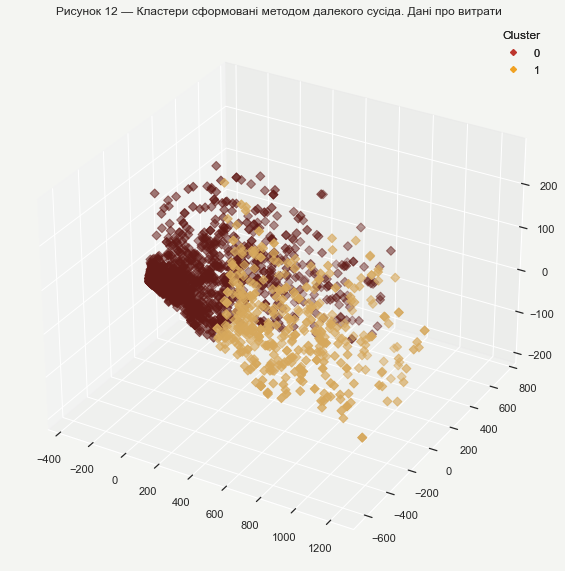

In [27]:
# Побудова графіку із кластерами сформованими методом далекого сусіда
fig = plt.figure(figsize = (10,10))
p = plt.subplot(111, projection = "3d", label = "bla")
p.scatter(x, y, z, s = 40, c = dataset["Clusters_complete"], marker ='D', cmap = cmap3)
p.set_title("Рисунок 12 — Кластери сформовані методом далекого сусіда. Дані про витрати")
legend1 = p.legend(*scatter.legend_elements(num=1), loc="upper right", title="Cluster")
p.add_artist(legend1)
plt.show();

Тепер поглянемо на кластеризацію тих даних, що містять інформацію про покупки із різних каналів продажу. Наші дії щодо процесу кластеризації цього набору даних аналогічні попереднім.

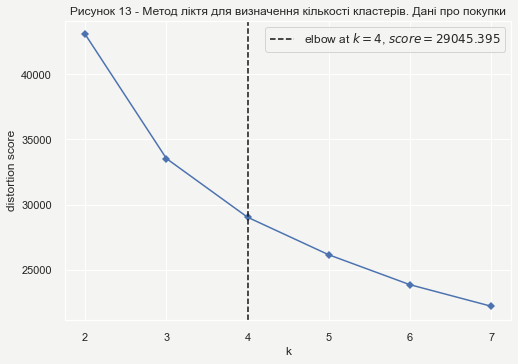

In [84]:
# Створення набору даних, що містять інформацію про кількість покупок клієнтів з різних каналів продажу
selected_col = dataset[["NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"]]
d_place = selected_col.copy()

# Метод ліктя для знаходження кількості кластерів для методу k-середніх
elbow_m = KElbowVisualizer(KMeans(), timings = False, k=7, locate_elbow = True, title = "Рисунок 13 - Метод ліктя для визначення кількості кластерів. Дані про покупки")
elbow_m.fit(d_place)
elbow_m.show();

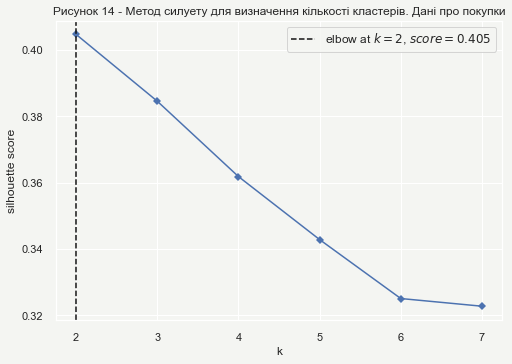

In [85]:
# Метод силуету для визначення кількості кластерів

visualizer = KElbowVisualizer(KMeans(), k=(2,8), metric = 'silhouette', timings= False, locate_elbow = True, title = 'Рисунок 14 - Метод силуету для визначення кількості кластерів. Дані про покупки')
visualizer.fit(d_place)
visualizer.show();

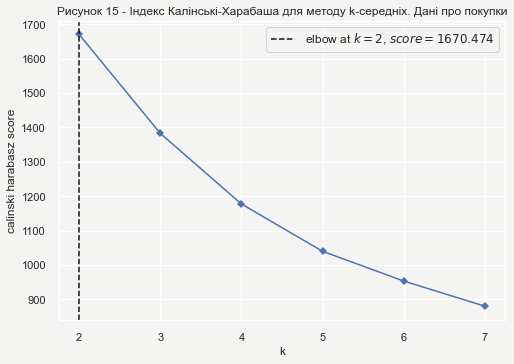

In [86]:
# Індекс Калінські-Харабаша для методу k-середніх

visualizer = KElbowVisualizer(KMeans(), k=(2,8), metric = 'calinski_harabasz', timings= False, locate_elbow = True, title = 'Рисунок 15 - Індекс Калінські-Харабаша для методу k-середніх. Дані про покупки')
visualizer.fit(d_place) 
visualizer.show();

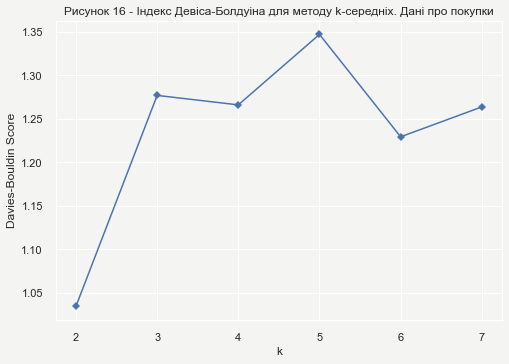

In [31]:
# Індекс Девіcа-Болдуіна для методу k-середніх

res = {}

for i in range(2,8):
    kmeans = KMeans(n_clusters=i, random_state=60)
    labels = kmeans.fit_predict(d_place)
    db_index = davies_bouldin_score(d_place, labels)
    res.update({i: db_index})
    
plt.plot(list(res.keys()), list(res.values()), marker="D")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Score")
plt.title('Рисунок 16 - Індекс Девіcа-Болдуіна для методу k-середніх. Дані про покупки')
plt.show();

Метод ліктя пропонує обрати три або чотири кластери, але метод силуету та індекси Калінські-Харабаша і Девіса-Болдуіна пропонують обрати два. Тому оберемо кількість k рівну двом.

In [32]:
# Метод k-середніх
k_meansss = KMeans(n_clusters = 2, init = 'k-means++', random_state = 55)

# підганяємо модель і передбачаємо кластери
cl_kmeansss = k_meansss.fit_predict(d_place)

# Додаємо змінну Clusters_kmeans до вихідного фрейму даних
dataset["Clusters_kmeans_place"] = cl_kmeansss


# Модель агломеративної кластеризації к = 3 методом Ворда
agccc = AgglomerativeClustering(n_clusters=2, linkage = 'ward')

# підганяємо модель і передбачаємо кластери
cl_agccc = agccc.fit_predict(d_place)

# Додаємо змінну Clusters_ward до вихідного фрейму даних.
dataset["Clusters_ward_place"]= cl_agccc


# Модель агломеративної кластеризації к = 3 методом далекого сусіда
agc_complll = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')

# підганяємо модель і передбачаємо кластери
cl_agc_complll = agc_complll.fit_predict(d_place)

# Додаємо змінну Clusters_ward до вихідного фрейму даних.
dataset["Clusters_complete_place"]= cl_agc_complll

**Зменшення розмірності за допомогою МГК**  

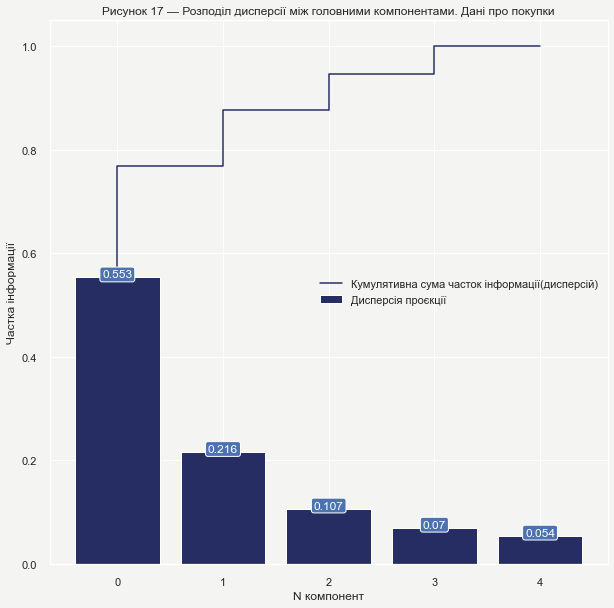

In [33]:
pca_pl = PCA()
pca_pl.fit(d_place)

cumsum_eigenv = np.cumsum(pca_pl.explained_variance_ratio_)

plt.figure(figsize=(10, 10))
plt.bar(range(0, len(pca_pl.explained_variance_ratio_)), pca_pl.explained_variance_ratio_,  label="Дисперсія проєкції", color = "#252d63")
add_value_label(range(0, len(pca_pl.explained_variance_ratio_)), pca_pl.explained_variance_ratio_)
plt.step(range(0, len(cumsum_eigenv)), cumsum_eigenv, label="Кумулятивна сума часток інформації(дисперсій)", color = "#252d63")
plt.xlabel("N компонент")
plt.ylabel("Частка інформації")
plt.legend(loc="center right")
plt.title("Рисунок 17 — Розподіл дисперсії між головними компонентами. Дані про покупки")
plt.show();

Оберемо три перших головних компоненти, які містять у собі біля 87% інформації, що є дуже гарним показником.

In [34]:
pca_pl = PCA(n_components=3)
pca_pl.fit(d_place)
PCA_place = pd.DataFrame(pca_pl.transform(d_place), columns=(["column1","column2", "column3"]))
PCA_place.describe().T

count          mean       std        min       25%       50%  \
column1  2202.0  1.548867e-16  4.362191 -10.378930 -3.750795  0.358367   
column2  2202.0  5.162890e-17  2.725613  -6.743398 -1.821470 -0.376754   
column3  2202.0 -2.420105e-17  1.916628  -6.811501 -0.927087 -0.192226   

              75%        max  
column1  4.144851  11.339627  
column2  1.629924  11.986755  
column3  0.757783  10.595122

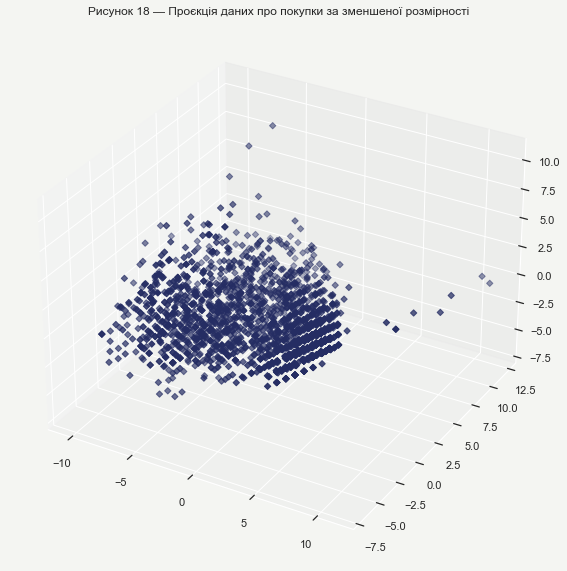

In [35]:
# Проєкція даних за зменшеної розмірності
x = PCA_place["column1"]
y = PCA_place["column2"]
z = PCA_place["column3"]

# Побудова
fig = plt.figure(figsize=(10,10))
ppl = fig.add_subplot(111, projection = "3d")
ppl.scatter(x, y, z, c="#252d63", marker="D" )
ppl.set_title("Рисунок 18 — Проєкція даних про покупки за зменшеної розмірності")
plt.show(); 

Тепер поглянемо на кластеризовані різними методами дані щодо каналів продажу у просторі трьох головних компонент.

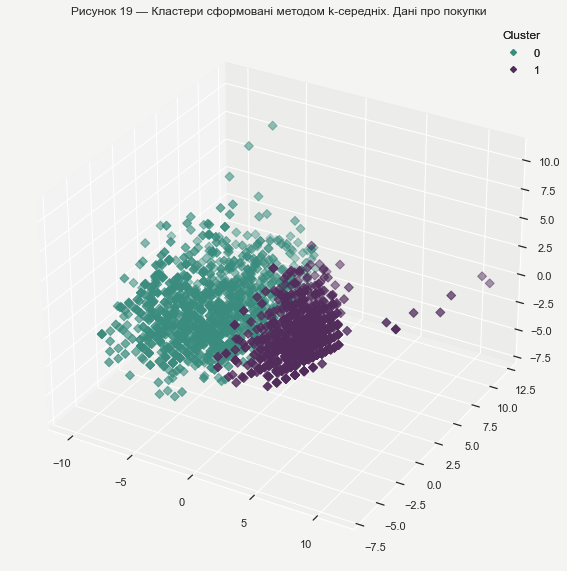

In [36]:
# Побудова графіку із кластерами

fig = plt.figure(figsize=(10,10))
p = plt.subplot(111, projection = "3d", label = "bla")
scatter = p.scatter(x, y, z, s = 40, c = dataset["Clusters_kmeans_place"], marker = 'D', cmap = cmap4)
p.set_title("Рисунок 19 — Кластери сформовані методом k-середніх. Дані про покупки")
legend1 = p.legend(*scatter.legend_elements(num=1), loc="upper right", title="Cluster")
p.add_artist(legend1)
plt.show();

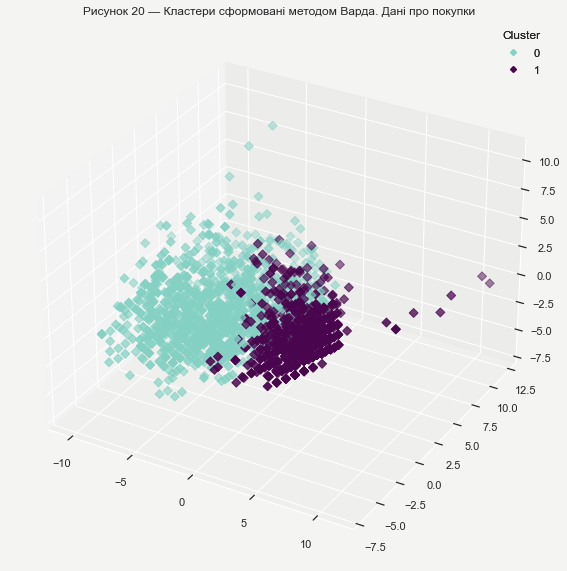

In [37]:
# Побудова графіку із кластерами сформованими методом Варда

fig = plt.figure(figsize = (10,10))
p = plt.subplot(111, projection = "3d", label = "bla")
scatter = p.scatter(x, y, z, s = 40, c = dataset["Clusters_ward_place"], marker ='D', cmap = cmap5)
p.set_title("Рисунок 20 — Кластери сформовані методом Варда. Дані про покупки")
legend1 = p.legend(*scatter.legend_elements(num=1), loc="upper right", title="Cluster")
p.add_artist(legend1)
plt.show();

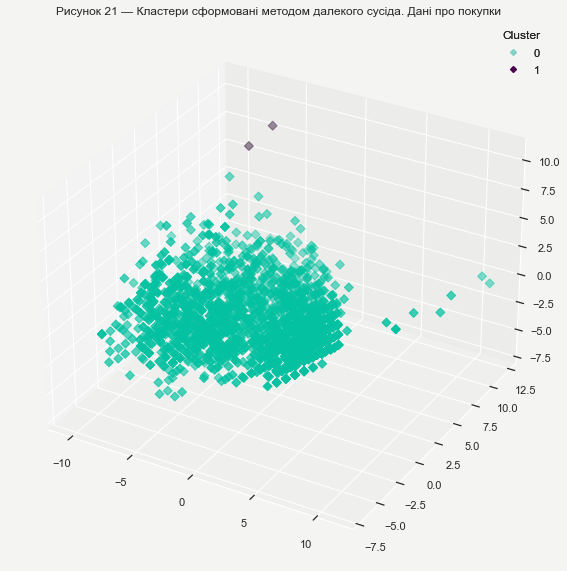

In [38]:
# Побудова графіку із кластерами сформованими методом далекого сусіда

fig = plt.figure(figsize = (10,10))
p = plt.subplot(111, projection = "3d", label = "bla")
p.scatter(x, y, z, s = 40, c = dataset["Clusters_complete_place"], marker ='D', cmap = cmap6)
p.set_title("Рисунок 21 — Кластери сформовані методом далекого сусіда. Дані про покупки")
legend1 = p.legend(*scatter.legend_elements(num=1), loc="upper right", title="Cluster")
p.add_artist(legend1)
plt.show();

## Оцінювання моделей

Оскільки кластеризація - це метод навчання без учителя, складно оцінити якість кластеризації. Тому в цьому розділі вивчимо закономірності в утворених різними методами кластерах із даних про купівельну поведінку та з даних про покупки з різних каналів продажів.

Для цього розглядатимемо уже кластеризовані дані шляхом розвідувального аналізу даних та зробимо висновки.

Спершу поглянемо як розподілені кластери.

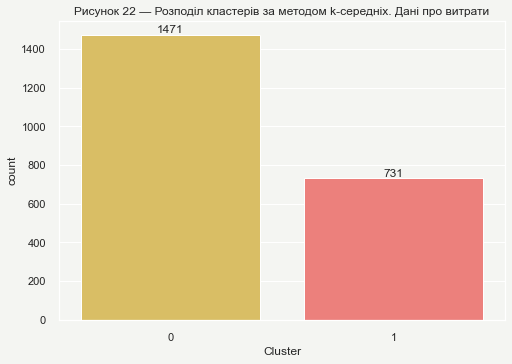

In [39]:
pl = sns.countplot(x = dataset["Clusters_kmeans"], palette = pallet1)
pl.bar_label(pl.containers[0])
pl.set(xlabel="Cluster")
pl.set_title("Рисунок 22 — Розподіл кластерів за методом k-середніх. Дані про витрати")
plt.show();

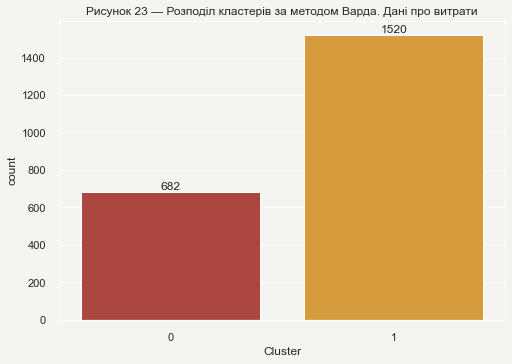

In [40]:
pl = sns.countplot(x = dataset["Clusters_ward"], palette = pallet2)
pl.bar_label(pl.containers[0])
pl.set(xlabel="Cluster")
pl.set_title("Рисунок 23 — Розподіл кластерів за методом Варда. Дані про витрати")
plt.show();

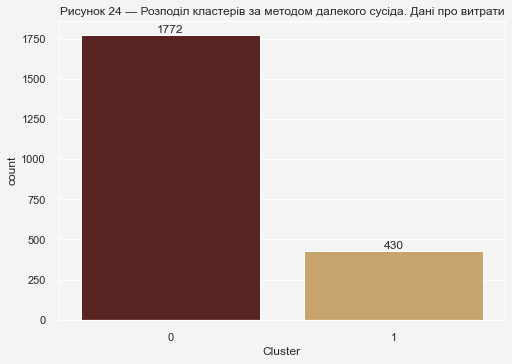

In [41]:
pl = sns.countplot(x = dataset["Clusters_complete"], palette = pallet3)
pl.bar_label(pl.containers[0])
pl.set(xlabel="Cluster")
pl.set_title("Рисунок 24 — Розподіл кластерів за методом далекого сусіда. Дані про витрати")
plt.show();

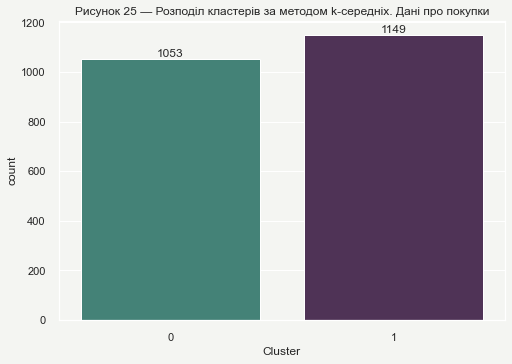

In [42]:
pl = sns.countplot(x = dataset["Clusters_kmeans_place"], palette = pallet4)
pl.bar_label(pl.containers[0])
pl.set(xlabel="Cluster")
pl.set_title("Рисунок 25 — Розподіл кластерів за методом k-середніх. Дані про покупки")
plt.show();

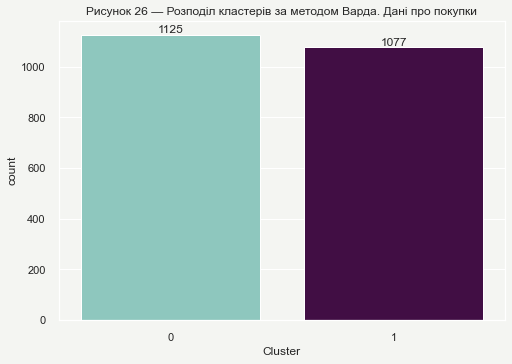

In [43]:
pl = sns.countplot(x = dataset["Clusters_ward_place"], palette = pallet5)
pl.bar_label(pl.containers[0])
pl.set(xlabel="Cluster")
pl.set_title("Рисунок 26 — Розподіл кластерів за методом Варда. Дані про покупки")
plt.show();

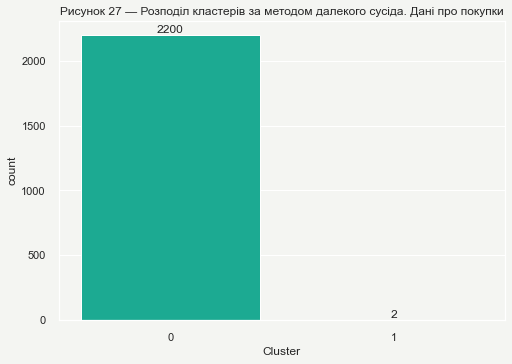

In [44]:
pl = sns.countplot(x = dataset["Clusters_complete_place"], palette = pallet6)
pl.bar_label(pl.containers[0])
pl.set(xlabel="Cluster")
pl.set_title("Рисунок 27 — Розподіл кластерів за методом далекого сусіда. Дані про покупки")
plt.show();

Бачимо, що метод далекого сусіда дуже нерівномірно розділив кластери, а методи Варда та k-середніх по-схожому сформували і дані про купівельну поведінку(витрати), і дані про покупки з різних каналів продажу(покупки).

Тепер поглянемо як розподілені об'єкти у кластерах сформованих методами k-середніх та Варда відносно Income та Spent(доходу та витрат).

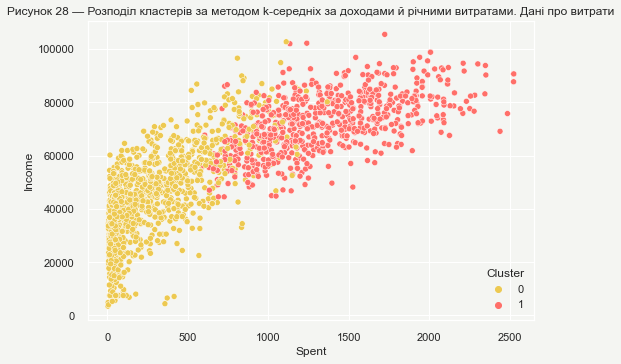

In [45]:
pal = sns.scatterplot(data = dataset, x = dataset["Spent"], y = dataset["Income"], hue = dataset["Clusters_kmeans"], palette = pallet1)
pal.set_title("Рисунок 28 — Розподіл кластерів за методом k-середніх за доходами й річними витратами. Дані про витрати")
plt.legend(loc="lower right", title="Cluster")
plt.show();

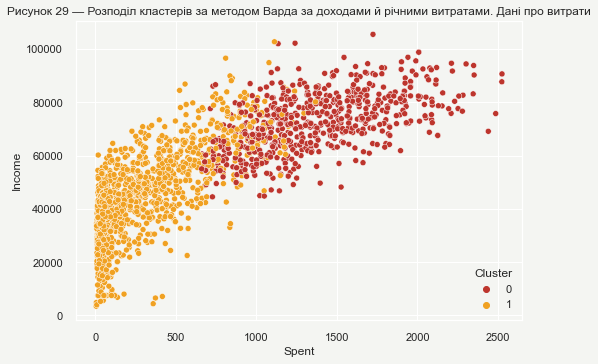

In [46]:
pal = sns.scatterplot(data = dataset, x = dataset["Spent"], y = dataset["Income"], hue = dataset["Clusters_ward"], palette = pallet2)
pal.set_title("Рисунок 29 — Розподіл кластерів за методом Варда за доходами й річними витратами. Дані про витрати")
plt.legend(loc="lower right", title="Cluster")
plt.show();

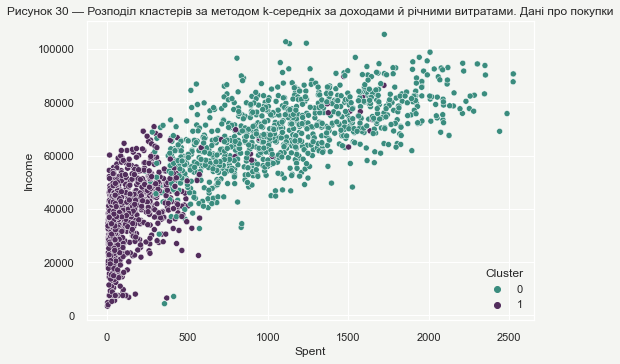

In [47]:
pal = sns.scatterplot(data = dataset, x = dataset["Spent"], y = dataset["Income"], hue = dataset["Clusters_kmeans_place"], palette = pallet4)
pal.set_title("Рисунок 30 — Розподіл кластерів за методом k-середніх за доходами й річними витратами. Дані про покупки")
plt.legend(loc="lower right", title="Cluster")
plt.show();

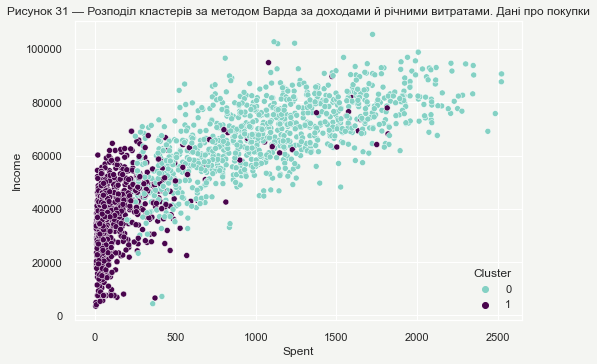

In [48]:
pal = sns.scatterplot(data = dataset, x = dataset["Spent"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], palette = pallet5)
pal.set_title("Рисунок 31 — Розподіл кластерів за методом Варда за доходами й річними витратами. Дані про покупки")
plt.legend(loc="lower right", title="Cluster")
plt.show();

Бачимо, що кластери сформовані із двох окремих наборів даних є трохи схожими, проте різняться вони кількістю об'єктів, що містять в собі. Оскільки метод Варда та метод k-середніх формували схожі кластери, то оберемо ті, що створені за допомогою методу Варда.

## Профілювання клієнтів

Тепер, коли сформовані кластери клієнтів за їх купівельною поведінкою та за покупками з різних каналів продажу, варто подивитися, ким представлений кожен кластер. Для цього потрібно профілювати сформовані кластери, щоб з'ясувати, який тип клієнта нині є найбільш зацікавленим у витратах та покупках у магазині, а якому потрібно більше уваги з боку маркетингової команди.

Щоб це з'ясувати будемо дивитися на розподіл кластерів по різних характеристиках. На основі цього будуть побудовані висновки. Для профілювання оберемо кластеризацію здійснену методом Варда для двох наборів даних даних, що містять відповідно інформацію про купівельну поведінку клієнтів(витрати) та про кількість покупок із різних каналів продажу(покупки).

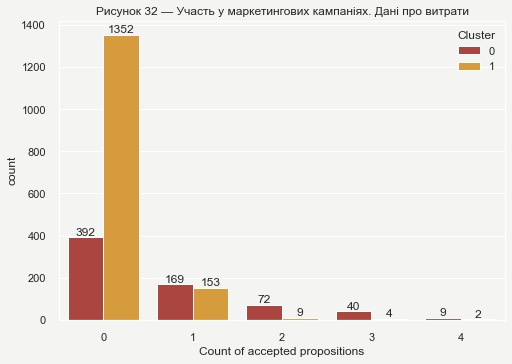

In [49]:
# Створення змінної, що є сумою колонок, що відображають участь у маркетингових кампаніях
dataset["AcceptedAll"] = dataset["AcceptedCmp1"]+ dataset["AcceptedCmp2"]+ dataset["AcceptedCmp3"]+ dataset["AcceptedCmp4"]+ dataset["AcceptedCmp5"]

# Зображення розподілу по сумах 
plt.figure()
pal = sns.countplot(x = dataset["AcceptedAll"], hue = dataset["Clusters_ward"], palette = pallet2)
pal.set_title("Рисунок 32 — Участь у маркетингових кампаніях. Дані про витрати")
pal.set_xlabel("Count of accepted propositions")
pal.legend(title="Cluster")
pal.bar_label(pal.containers[0])
pal.bar_label(pal.containers[1])
plt.show();

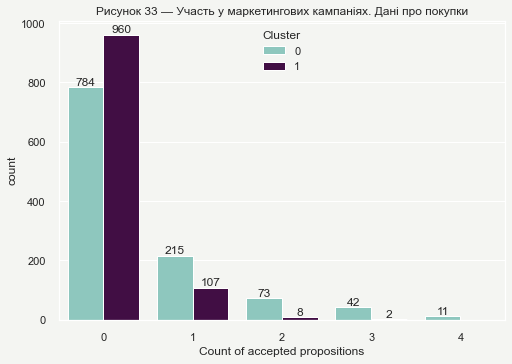

In [50]:
# Зображення розподілу по сумах 
plt.figure()
pal = sns.countplot(x = dataset["AcceptedAll"], hue = dataset["Clusters_ward_place"], palette = pallet5)
pal.set_title("Рисунок 33 — Участь у маркетингових кампаніях. Дані про покупки")
pal.set_xlabel("Count of accepted propositions")
pal.legend(title="Cluster")
pal.bar_label(pal.containers[0])
pal.bar_label(pal.containers[1])
plt.show();

Великої кількості учасників у маркетингових кампаніях ми не спостерігаємо. Окрім того, ніхто не бере участі у всіх п'яти маркетингових кампаніях. Можливо, для збільшення продажів необхідно краще продумати самі кампанії.

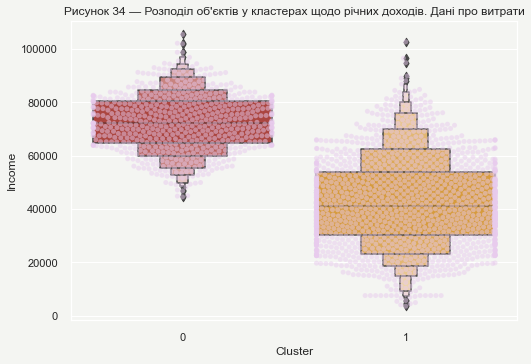

In [51]:
plt.figure()
pal = sns.swarmplot(x = dataset["Clusters_ward"], y = dataset["Income"], color= "#e8cbed", alpha=0.5 )
pal = sns.boxenplot(x = dataset["Clusters_ward"], y = dataset["Income"], palette = pallet2)
pal.set(xlabel='Cluster')
pal.set_title("Рисунок 34 — Розподіл об'єктів у кластерах щодо річних доходів. Дані про витрати")
plt.show();

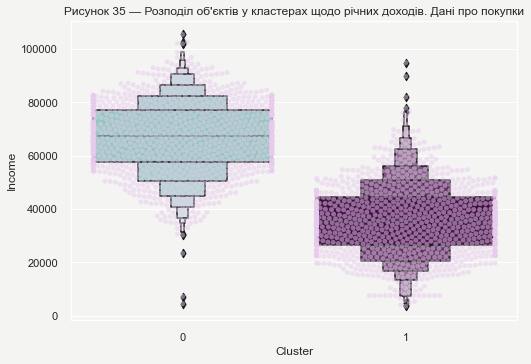

In [52]:
plt.figure()
pal = sns.swarmplot(x = dataset["Clusters_ward_place"], y = dataset["Income"], color= "#e8cbed", alpha=0.5 )
pal = sns.boxenplot(x = dataset["Clusters_ward_place"], y = dataset["Income"], palette = pallet5)
pal.set(xlabel='Cluster')
pal.set_title("Рисунок 35 — Розподіл об'єктів у кластерах щодо річних доходів. Дані про покупки")
plt.show();

Щодо загальних доходів кластери із різних наборів даних є дуже схожими.

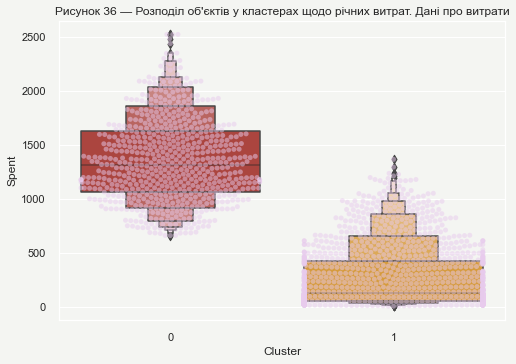

In [53]:
plt.figure()
pal = sns.swarmplot(x = dataset["Clusters_ward"], y = dataset["Spent"], color= "#e8cbed", alpha=0.5 )
pal = sns.boxenplot(x = dataset["Clusters_ward"], y = dataset["Spent"], palette = pallet2)
pal.set(xlabel='Cluster')
pal.set_title("Рисунок 36 — Розподіл об'єктів у кластерах щодо річних витрат. Дані про витрати")
plt.show();

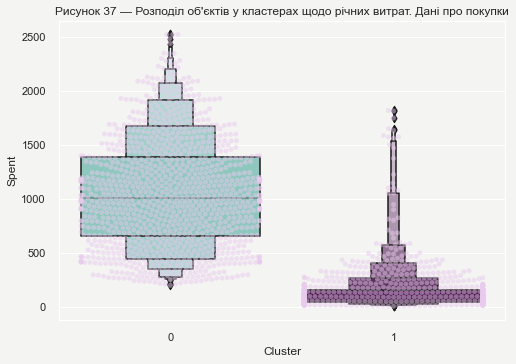

In [54]:
plt.figure()
pal = sns.swarmplot(x = dataset["Clusters_ward_place"], y = dataset["Spent"], color= "#e8cbed", alpha=0.5 )
pal = sns.boxenplot(x = dataset["Clusters_ward_place"], y = dataset["Spent"], palette = pallet5)
pal.set(xlabel='Cluster')
pal.set_title("Рисунок 37 — Розподіл об'єктів у кластерах щодо річних витрат. Дані про покупки")
plt.show();

А от щодо річних витрат кластери сформувалися трохи по-різному.

<Figure size 576x396 with 0 Axes>

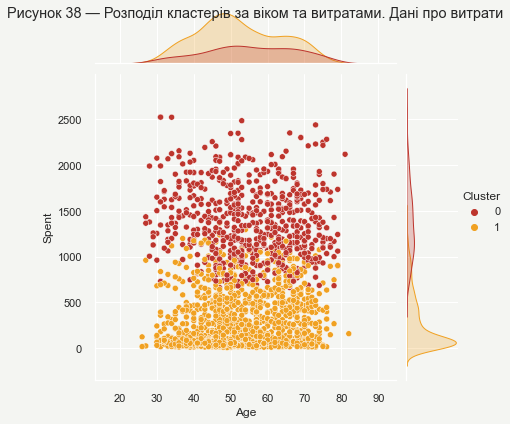

In [55]:
plt.figure()
plo = sns.jointplot(x = dataset["Age"], y = dataset["Spent"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 38 — Розподіл кластерів за віком та витратами. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

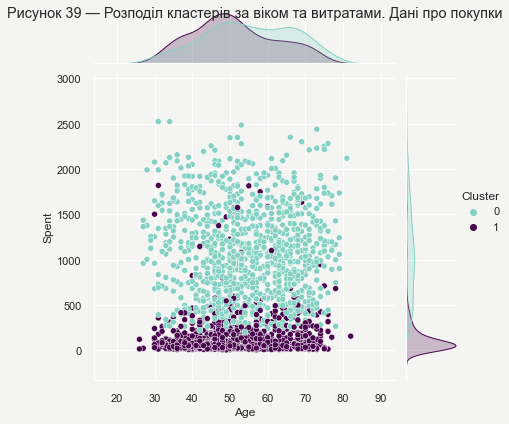

In [56]:
plt.figure()
plo = sns.jointplot(x = dataset["Age"], y = dataset["Spent"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 39 — Розподіл кластерів за віком та витратами. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

Бачимо, що у двох наборах даних кластери розподілили дані за ознакою віку по-схожому. У першому та другому кластерах сформованих на основі цих даних - клієнти всіх вікових категорій.

<Figure size 576x396 with 0 Axes>

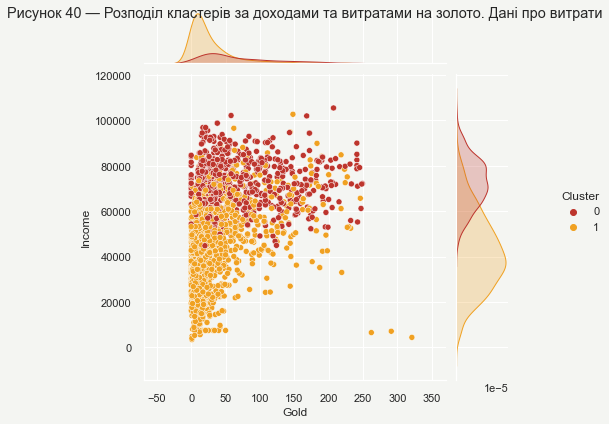

In [57]:
plt.figure()
plo = sns.jointplot(x = dataset["Gold"], y = dataset["Income"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 40 — Розподіл кластерів за дохoдами та витратами на золото. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

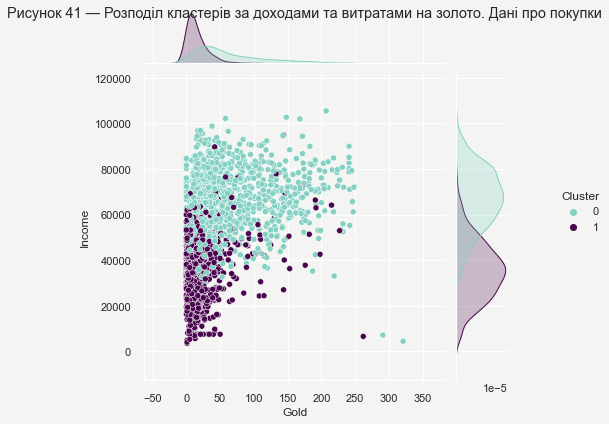

In [58]:
plt.figure()
plo = sns.jointplot(x = dataset["Gold"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 41 — Розподіл кластерів за дохoдами та витратами на золото. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

Бачимо, що кластери сформовані з набору даних про купівельну поведінку клієнтів(витрати) трохи відрізняються від сформованих кластерів за покупками з різних каналів продажу. Ми бачимо, що Кластер 1, сформований з даних про витрати, який представляє собою групу людей, що мають низький дохід все ж, витрачають великі суми на золото, а от у Кластері 1, який сформований з даних про покупки, набагато менше таких людей.

<Figure size 576x396 with 0 Axes>

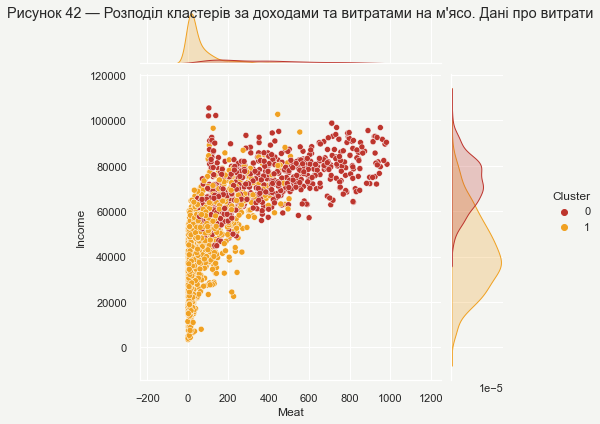

In [59]:
plt.figure()
plo = sns.jointplot(x = dataset["Meat"], y = dataset["Income"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 42 — Розподіл кластерів за дохoдами та витратами на м'ясо. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

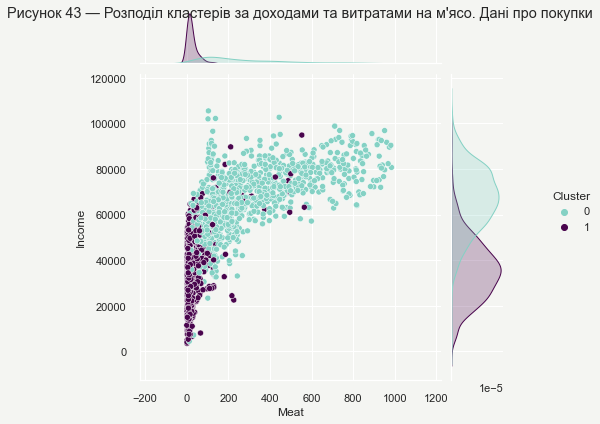

In [60]:
plt.figure()
plo = sns.jointplot(x = dataset["Meat"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 43 — Розподіл кластерів за дохoдами та витратами на м'ясо. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

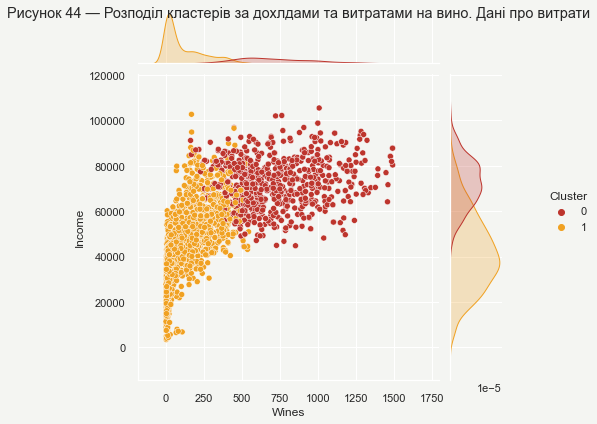

In [61]:
plt.figure()
plo = sns.jointplot(x = dataset["Wines"], y = dataset["Income"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 44 — Розподіл кластерів за дохлдами та витратами на вино. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

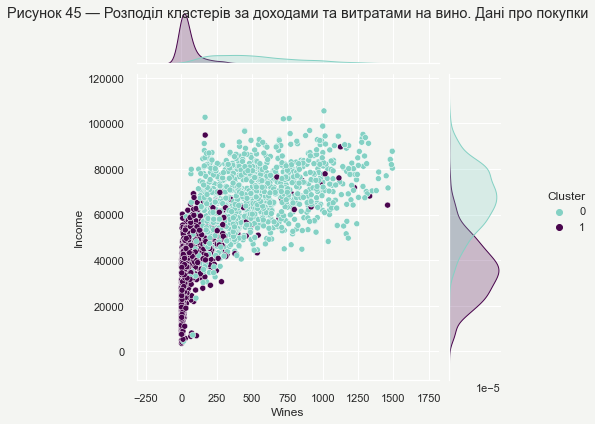

In [62]:
plt.figure()
plo = sns.jointplot(x = dataset["Wines"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 45 — Розподіл кластерів за доходами та витратами на вино. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

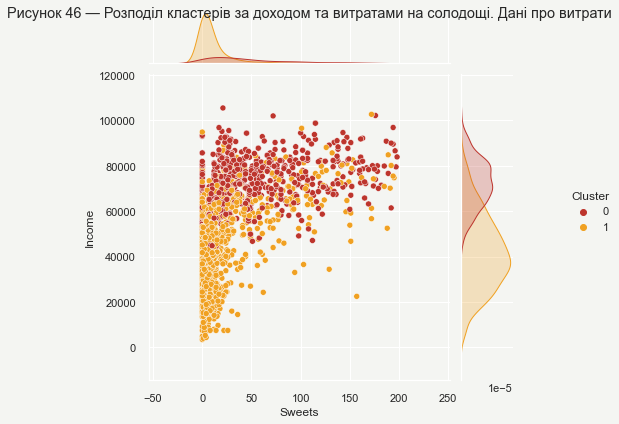

In [63]:
plt.figure()
plo = sns.jointplot(x = dataset["Sweets"], y = dataset["Income"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 46 — Розподіл кластерів за доходом та витратами на солодощі. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

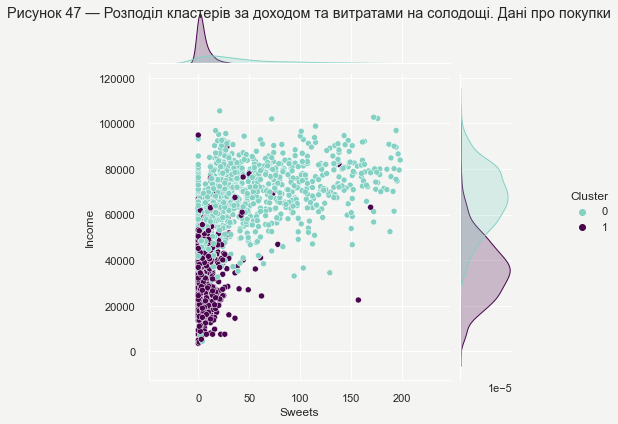

In [64]:
plt.figure()
plo = sns.jointplot(x = dataset["Sweets"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 47 — Розподіл кластерів за доходом та витратами на солодощі. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

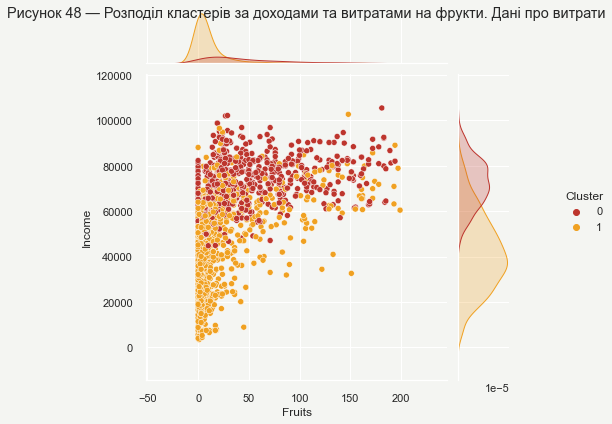

In [65]:
plt.figure()
plo = sns.jointplot(x = dataset["Fruits"], y = dataset["Income"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 48 — Розподіл кластерів за доходами та витратами на фрукти. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

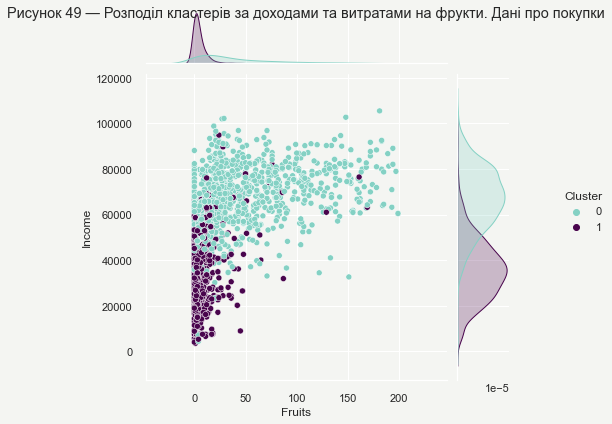

In [66]:
plt.figure()
plo = sns.jointplot(x = dataset["Fruits"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 49 — Розподіл кластерів за доходами та витратами на фрукти. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

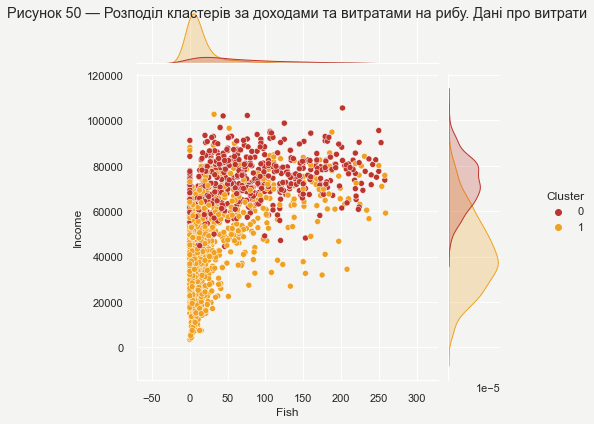

In [67]:
plt.figure()
plo = sns.jointplot(x = dataset["Fish"], y = dataset["Income"], hue = dataset["Clusters_ward"], kind = "scatter", palette = pallet2)
plo.fig.suptitle("Рисунок 50 — Розподіл кластерів за доходами та витратами на рибу. Дані про витрати")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

<Figure size 576x396 with 0 Axes>

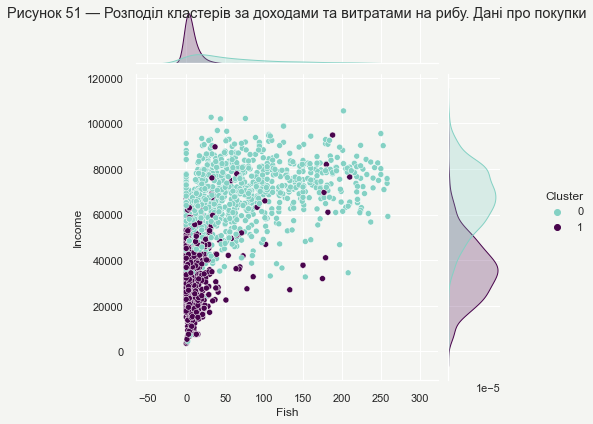

In [68]:
plt.figure()
plo = sns.jointplot(x = dataset["Fish"], y = dataset["Income"], hue = dataset["Clusters_ward_place"], kind = "scatter", palette = pallet5)
plo.fig.suptitle("Рисунок 51 — Розподіл кластерів за доходами та витратами на рибу. Дані про покупки")
plo.ax_joint.legend_._visible=False
plo.fig.legend(loc='center right', title="Cluster")
plt.show();

Так само можна сказати і про витрати на всі інші продукти. Напевно, кластери, що сформовані для даних про покупки з різних каналів продажу, також гарно поділяють наші початкові дані про витрати на різні типи продуктів, на графіках ми бачимо менше розсіювання об'єктів щодо витрат на конкретний продукт, що й підштовхує на такий висновок.

Поглянемо, як розподілилися Кластери щодо окремих каналів продажів для наших двох наборів даних.

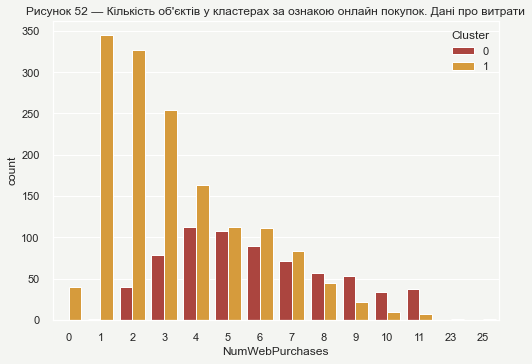

In [69]:
plt.figure()
c = sns.countplot(x = dataset["NumWebPurchases"], hue = dataset["Clusters_ward"], palette = pallet2)
plt.title("Рисунок 52 — Кількість об'єктів у кластерах за ознакою онлайн покупок. Дані про витрати")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

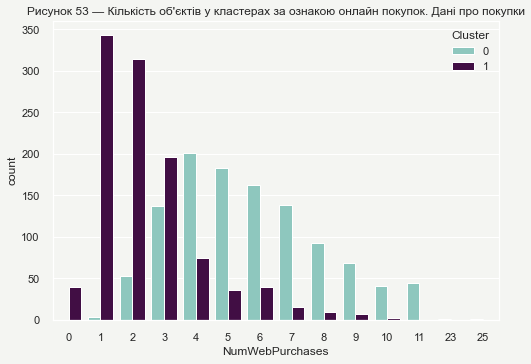

In [70]:
plt.figure()
c = sns.countplot(x = dataset["NumWebPurchases"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 53 — Кількість об'єктів у кластерах за ознакою онлайн покупок. Дані про покупки")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

Бачимо, що кластери, сформовані з даних про покупки краще описують зацікавленість у покупках із різних каналів. Описати їх можна так: Кластер 1 здебільшого здійснює від двох до чотирьох онлайн покупок, або узагалі не здійснює їх, в той час як Кластер 0 здійснює від двох до одинадцяти покупок онлайн.

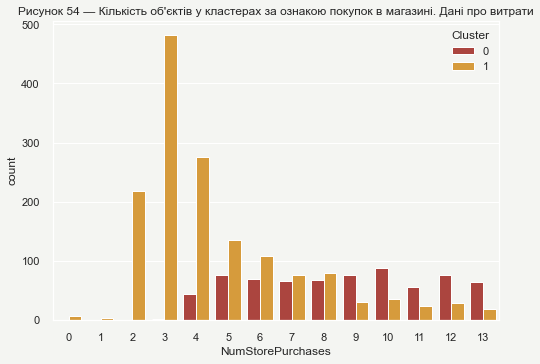

In [71]:
plt.figure()
c = sns.countplot(x = dataset["NumStorePurchases"], hue = dataset["Clusters_ward"], palette = pallet2)
plt.title("Рисунок 54 — Кількість об'єктів у кластерах за ознакою покупок в магазині. Дані про витрати")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

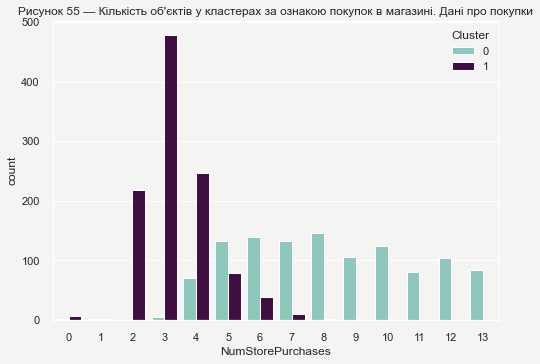

In [72]:
plt.figure()
c = sns.countplot(x = dataset["NumStorePurchases"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 55 — Кількість об'єктів у кластерах за ознакою покупок в магазині. Дані про покупки")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

Аналогічно і тут кластери, що сформувалися з даних про кількість покупок із різних каналів продажу, краще описують зацікавленість клієнтів у покупках. Кластер 1 здійснює здебільшого від двох до чотирьох покупок у магазині, тоді як Кластер 0 від чотирьох до тринадцяти.

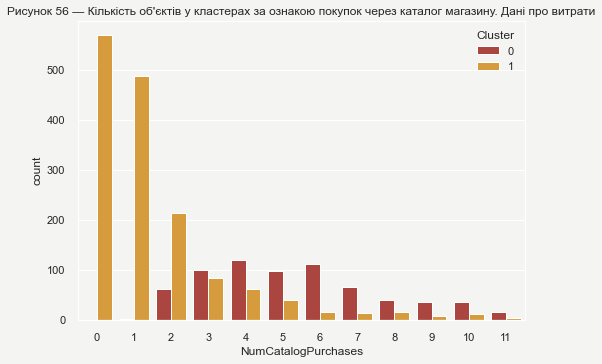

In [73]:
plt.figure()
c = sns.countplot(x = dataset["NumCatalogPurchases"], hue = dataset["Clusters_ward"], palette = pallet2)
plt.title("Рисунок 56 — Кількість об'єктів у кластерах за ознакою покупок через каталог магазину. Дані про витрати")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

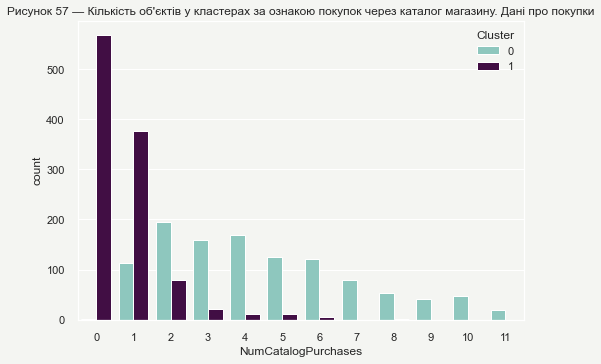

In [74]:
plt.figure()
c = sns.countplot(x = dataset["NumCatalogPurchases"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 57 — Кількість об'єктів у кластерах за ознакою покупок через каталог магазину. Дані про покупки")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

Така ж ситуація щодо кількості покупок через каталог магазину. Бачимо, що Кластер 1 здебільшого або здійснює одну покупку, або не здійснює жодної, в той час як Кластер 0 - від однієї до одинадцяти.

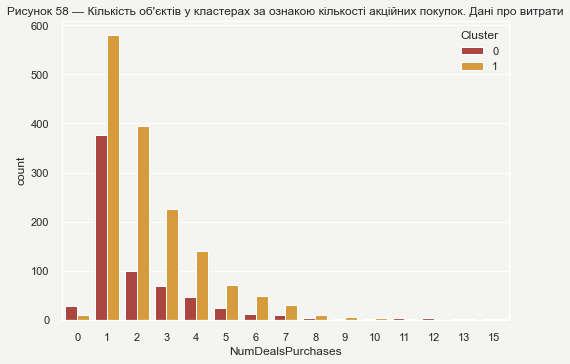

In [75]:
plt.figure()
c = sns.countplot(x = dataset["NumDealsPurchases"], hue = dataset["Clusters_ward"], palette = pallet2)
plt.title("Рисунок 58 — Кількість об'єктів у кластерах за ознакою кількості акційних покупок. Дані про витрати")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

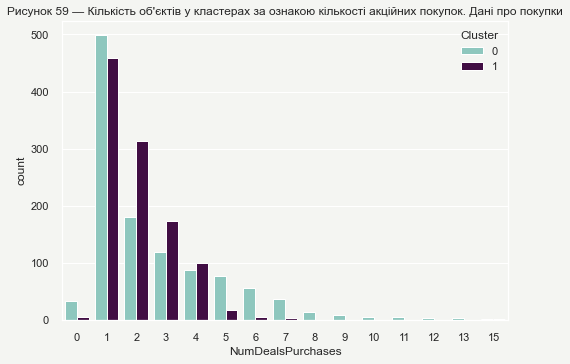

In [76]:
plt.figure()
c = sns.countplot(x = dataset["NumDealsPurchases"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 59 — Кількість об'єктів у кластерах за ознакою кількості акційних покупок. Дані про покупки")
plt.legend(title = "Cluster", loc="upper right")
plt.show();

А от щодо акційних покупок, то кластери сформовані по-схожому.

Здається, що побудовані з даних про покупки з різних каналів продажу краще розділені, далі ми будемо описувати клієнтів, базуючись саме на них.

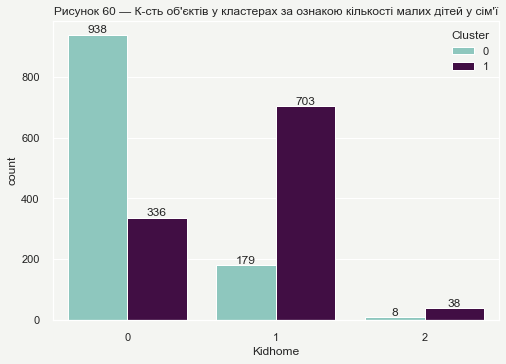

In [77]:
plt.figure()
c = sns.countplot(x = dataset["Kidhome"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 60 — К-сть об'єктів у кластерах за ознакою кількості малих дітей у сім'ї")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.show();

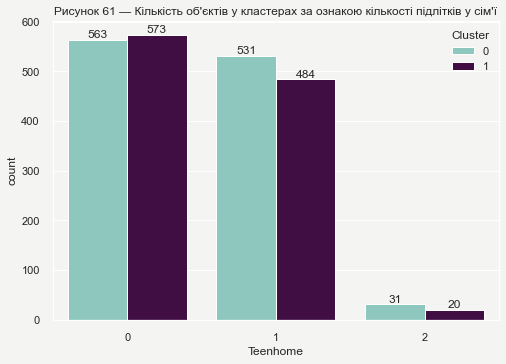

In [78]:
plt.figure()
c = sns.countplot(x = dataset["Teenhome"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 61 — Кількість об'єктів у кластерах за ознакою кількості підлітків у сім'ї")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.show();

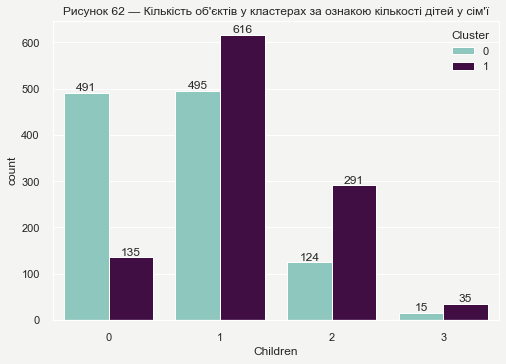

In [79]:
plt.figure()
c = sns.countplot(x = dataset["Children"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 62 — Кількість об'єктів у кластерах за ознакою кількості дітей у сім'ї")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.show();

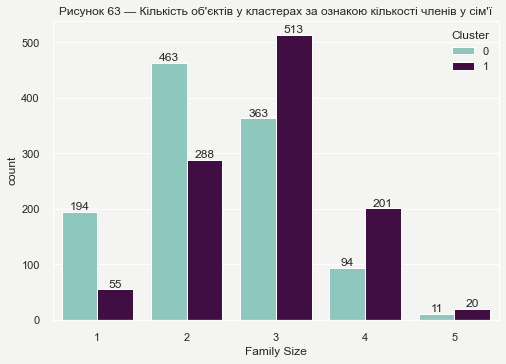

In [80]:
plt.figure()
c = sns.countplot(x = dataset["Family_Size"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 63 — Кількість об'єктів у кластерах за ознакою кількості членів у сім'ї")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.xlabel("Family Size")
plt.show();

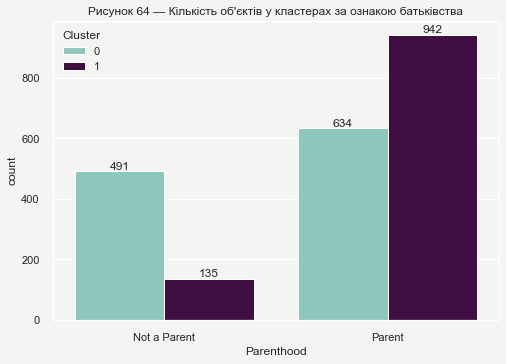

In [81]:
plt.figure()
c = sns.countplot(x = dataset["Parenthood"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 64 — Кількість об'єктів у кластерах за ознакою батьківства")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.show();

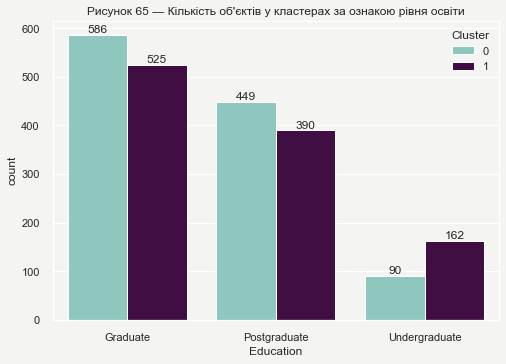

In [82]:
plt.figure()
c = sns.countplot(x = dataset["Education"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 65 — Кількість об'єктів у кластерах за ознакою рівня освіти")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.show();

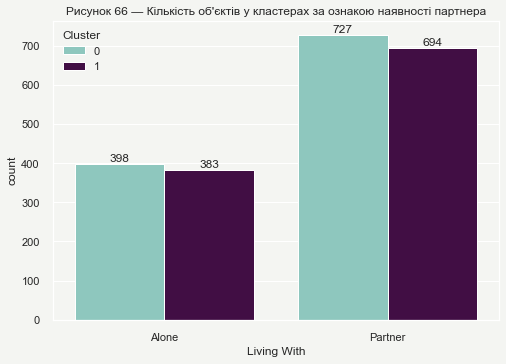

In [83]:
plt.figure()
c = sns.countplot(x = dataset["Living_With"], hue = dataset["Clusters_ward_place"], palette = pallet5)
plt.title("Рисунок 66 — Кількість об'єктів у кластерах за ознакою наявності партнера")
plt.legend(title = "Cluster")
plt.bar_label(c.containers[0])
plt.bar_label(c.containers[1])
plt.xlabel("Living With")
plt.show();

Оскільки кластери, що сформовані з даних про кількість покупок із різних каналів продажу містять приблизно однакову кількість об'єктів, із графіків вище ми можемо зробити такі висновки: за ознакою наявності партнера кластери схожі - більшість мають партнера; за ознакою рівня освіти також - майже всі мають вищу освіту; за ознакою наявності у сім'ї підлітка теж - половина має його.

Тепер можемо описати кластери клієнтів детальніше.

Щодо кластерів, можемо побачити такі закономірності:
- Кластер 1: Низький рівень витрат та низький рівень доходів
- Кластер 0: Середній та високий рівень витрат та високий рівень доходів


**Кластер 0:** 
- Містить 1125 об'єктів
- Високий та середній рівень витрат та високий рівень доходів
- Більшість мають партнера
- Половина має одну дитину, половина не має дітей узагалі
- Здебільшого у сім'ї клієнта - від однієї до трьох осіб
- Майже всі мають вищу освіту(Graduate, Post Graduate)
- Різних вікових категорій
- Витрачають більші суми на усі види продуктів
- Зацікавлені у онлайн-покупках, покупках у магазині та покупках через каталог
- Більше зацікавлені у акційних пропозиціях та купують більше акційних продуктів

**Кластер 1**
- Містить 1077 об'єктів
- Низький рівень витрат та низький рівень доходів
- Більшість мають партнера
- Майже всі мають дітей(одну чи дві)
- Дві третини мають партнера, решта - ні
- У сім'ї здебільшого від двох до чотирьох осіб
- Майже всі мають вищу освіту(Graduate, Post Graduate)
- Різних вікових категорій
- Витрачають малі суми на усі види продуктів
- Здійснюють мало покупок через усі канали продажу
- Здійснюють небагато акційних покупок